#PROJECT 3

IMPORT PACKAGES

In [ ]:
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import requests
from sklearn.linear_model import LinearRegression as linreg

PRICE MOMENTUM FACTORS & IDENTIFYING LONG AND SHORT ASSETS

In [ ]:
class momentum_factors:
    def __init__(self, spy_listings, tickers):
        self.price, self.volume = spy_listings['Close'], spy_listings['Volume']
        self.returns = self.price.pct_change()
        self.tickers = tickers

        self.momentumdf = pd.DataFrame(index=self.tickers)

    def trend(self, input_df):
        self.input_df = input_df
        self.trend_df = pd.DataFrame(index=self.tickers)

        for i in range(1, 21):
            self.trend_df[i] = np.polyfit(
                range(252),
                self.input_df[-i-252: -i],
                1,
            )[0]

        return self.trend_df.mean(axis=1)

    def price_momentumfactors(self):

        # Run 52-Wk Trend Func.
        self.momentumdf["trend"] = self.trend(input_df=self.price)

        # Percent Above
        self.roll_min = self.price.rolling(252).min()
        self.momentumdf["pct_above"] = ((self.price - self.roll_min) / self.roll_min)[-20:].mean()

        # Price Osc.
        self.rolling_260 = self.price.rolling(260)
        self.momentumdf["p_osc"] = (
            (self.price.rolling(20).mean() - self.rolling_260.mean()) /
            self.rolling_260.std()
        )[-20:].mean()

        # 39-Wk Ret.
        self.momentumdf["39_wk_ret"] = self.price.pct_change(189)[-20:].mean()

        # Price Vol. Trend
        self.price_volumedf = self.price * self.volume
        self.momentumdf["price_volume"] = self.trend(input_df=self.price_volumedf)

        return ((self.momentumdf - self.momentumdf.mean()) / self.momentumdf.std()).sum(axis=1)

    def baskets(self):
          self.momentumscore = self.price_momentumfactors()
          self.z_scored = self.momentumscore

          return self.z_scored.nlargest(10).index, self.z_scored.nsmallest(10).index


GATHERING SPY DATA

In [ ]:
ssga = "https://www.ssga.com/us/en/individual/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx"
spy_listings = list(pd.read_excel(ssga, header=4).Ticker.dropna())
data = yf.download(spy_listings, period="10y")
data = data.dropna(how="all", axis=1)
tickers = list(data['Close'])

[*********************100%***********************]  504 of 504 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=10y)')
ERROR:yfinance:['-', 'BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")')


BACKTESTING

In [ ]:
backtestlngth = 5
end = dt.datetime.today()
start = end - dt.timedelta(365.25 * backtestlngth)
freq = "M"
hist_rets = data['Close'].pct_change().resample('M').sum().shift(-1)
rangendtes = pd.DataFrame(pd.date_range('2018-12-01', dt.datetime.today(), freq ='M'))
rangendtes.rename (columns = {0: 'date'}, inplace = True)
longreturn, shortreturn = pd.DataFrame(), pd.DataFrame()

for date in rangendtes.date:
    try:
        MF = momentum_factors(data[data.index <= date], tickers)
        longbasket, shrtbasket = MF.baskets()
        longreturn = pd.concat([longreturn, hist_rets.loc[[date], longbasket]])
        shortreturn = pd.concat([shortreturn, hist_rets.loc[[date], shrtbasket]])
    except:
        pass

<ipython-input-33-b24e6bf756af>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hist_rets = data['Close'].pct_change().resample('M').sum().shift(-1)
<ipython-input-33-b24e6bf756af>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rangendtes = pd.DataFrame(pd.date_range('2018-12-01', dt.datetime.today(), freq ='M'))
<ipython-input-31-1f2cb8edc805>:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = self.price.pct_change()
<ipython-input-31-1f2cb8edc805>:39: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

In [ ]:
longbasket,shrtbasket


(Index(['PLTR', 'TSLA', 'BKNG', 'TPL', 'GEV', 'NFLX', 'AXON', 'AZO', 'FICO',
        'DASH'],
       dtype='object'),
 Index(['NVDA', 'AMD', 'REGN', 'MRNA', 'MTD', 'BIIB', 'FSLR', 'ENPH', 'TER',
        'ADBE'],
       dtype='object'))

VISUALIZATIONS

[*********************100%***********************]  1 of 1 completed


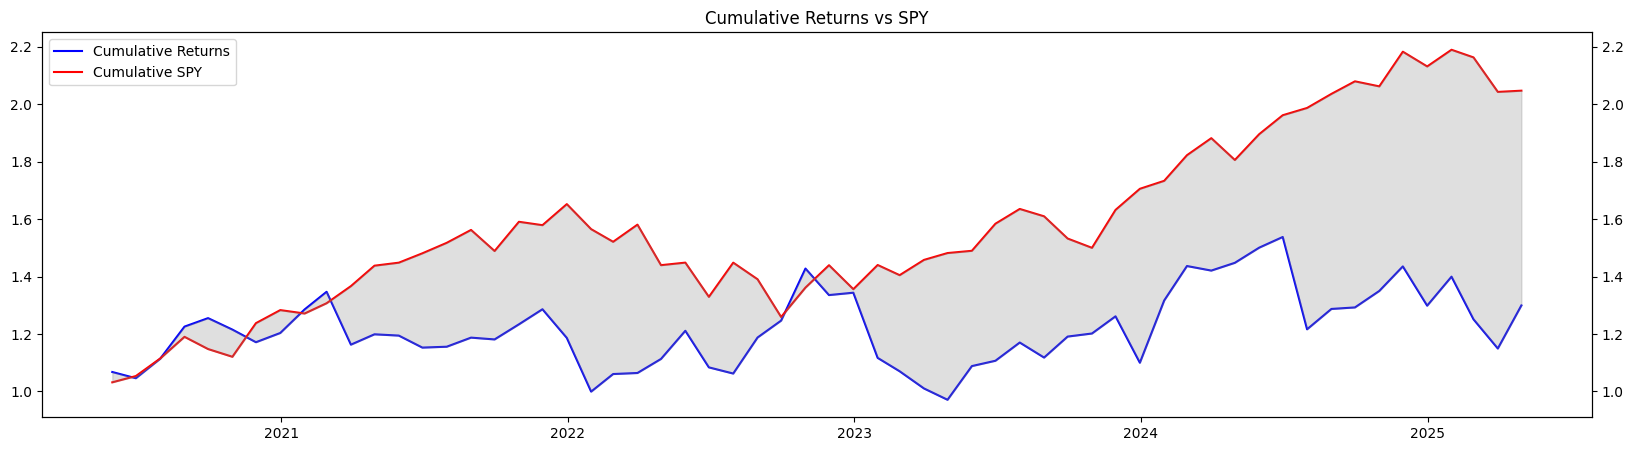

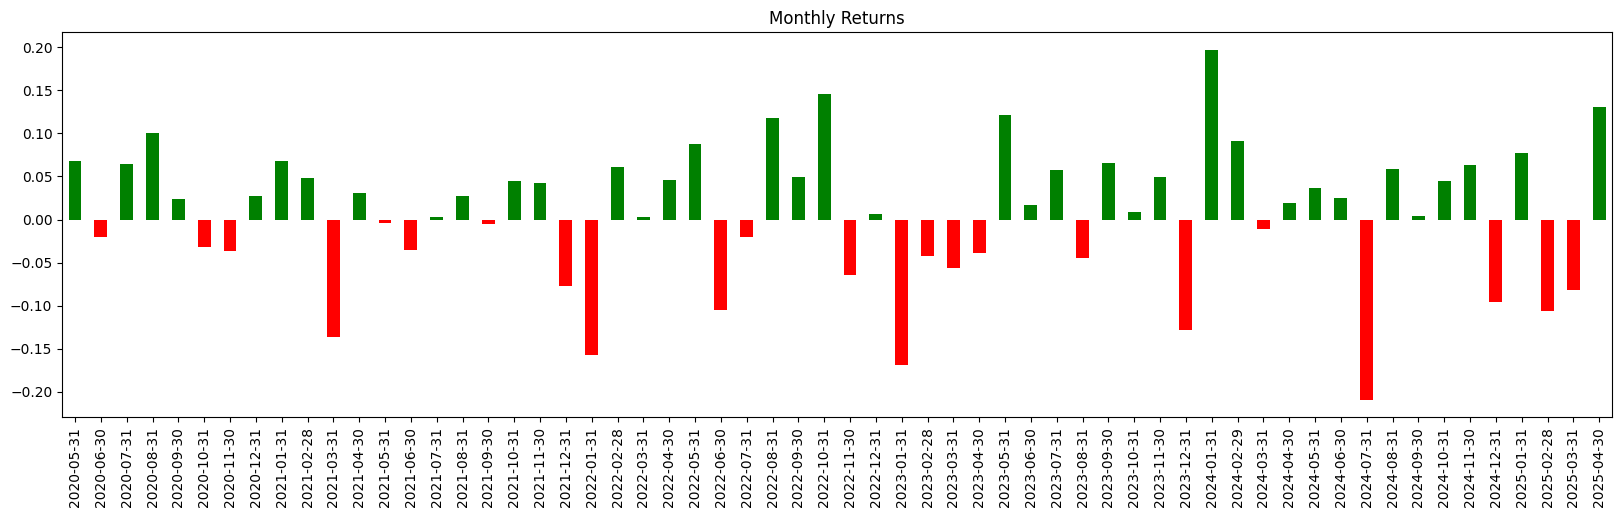

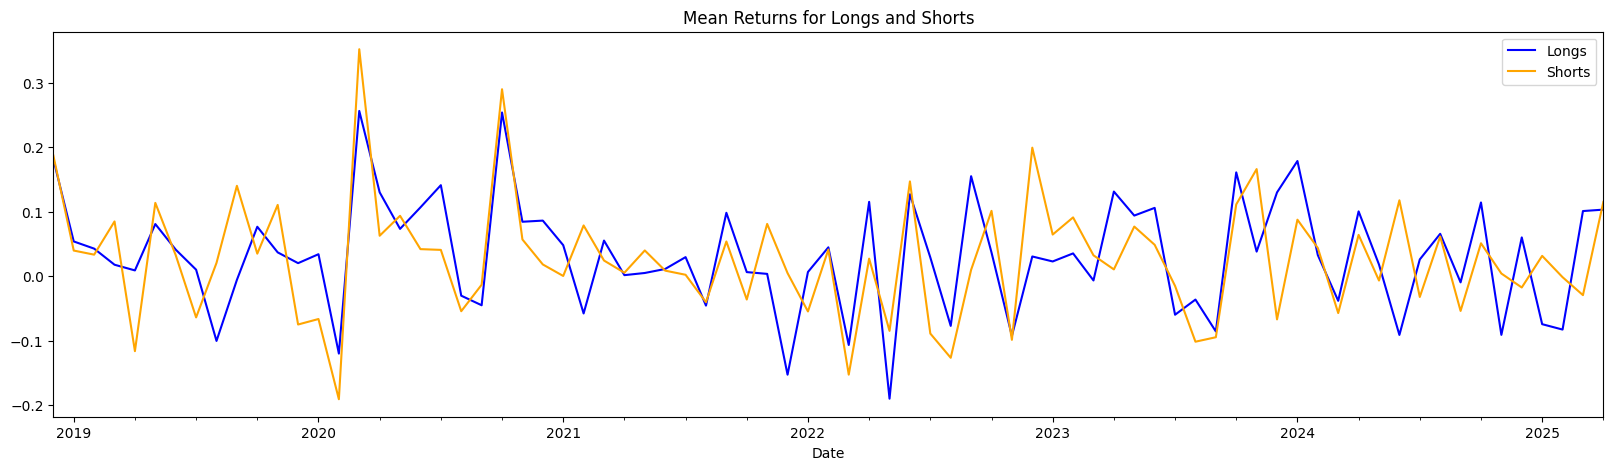

In [ ]:

# Calculate Total Returns
tottsretrns = pd.DataFrame((longreturn.mean(axis=1) - shortreturn.mean(axis=1)).shift(), columns=["tottsretrns"])
tottsretrns = tottsretrns[-60:]

# GRAPH 1: Cumulative Returns and Comparison with SPY
# Calculate cumulative returns
tottsretrns["cum_ret"] = np.exp(np.log1p(tottsretrns["tottsretrns"]).cumsum())

# Fetch and calculate SPY cumulative returns
spy_data = yf.download("SPY", period="5y")
spy_monthly_returns = spy_data["Close"].pct_change().resample("ME").sum()
tottsretrns["spy"] = spy_monthly_returns

tottsretrns["cum_spy"] = np.exp(np.log1p(tottsretrns["spy"].fillna(0)).cumsum())

# Calculate additional metrics
tottsretrns["pos"] = tottsretrns["tottsretrns"] > 0
tottsretrns["cum_vs"] = tottsretrns["cum_ret"] - tottsretrns["cum_spy"]
tottsretrns["cum_pos"] = tottsretrns["cum_vs"] > 0

# Convert index to date
tottsretrns.index = tottsretrns.index.date

# Plot cumulative returns
figure, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()

x = tottsretrns.index
ax2.fill_between(x, tottsretrns["cum_ret"], tottsretrns["cum_spy"], alpha=0.25, color="gray")
ax1.plot(x, tottsretrns["cum_ret"], label="Cumulative Returns", color="blue")
ax1.plot(x, tottsretrns["cum_spy"], label="Cumulative SPY", color="red")

ax1.legend(loc="upper left")
plt.title("Cumulative Returns vs SPY")
plt.show()

# GRAPH 2: Bar Plot of Total Returns with Positive/Negative Coloring
figure, ax2 = plt.subplots(figsize=(20, 5))
tottsretrns["tottsretrns"].plot(
    kind="bar",
    color=tottsretrns["pos"].map({True: "green", False: "red"}),
    ax=ax2
)

plt.title("Monthly Returns")
plt.show()

# GRAPH 3: Mean Returns for Longs and Shorts
figure, ax = plt.subplots(figsize=(20, 5))
longreturn.mean(axis=1).plot(label="Longs", color="blue", ax=ax)
shortreturn.mean(axis=1).plot(label="Shorts", color="orange", ax=ax)

plt.legend()
plt.title("Mean Returns for Longs and Shorts")
plt.show()


In [66]:
 stocks = longbasket.tolist()
 end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(2*365)
price = yf.download(stocks, period = '2y')['Close'].pct_change().dropna()
returns = price


[*********************100%***********************]  10 of 10 completed


In [67]:
class EfficientFrontier:
    def __init__(self,returns, assets):
        self.returns = returns
        self.assets = assets

    def Calc(self):
        self.tbl = pd.DataFrame(index = self.assets)
        self.tbl['Mean'] = self.returns.mean()
        self.tbl['Variance'] = self.returns.var()
        return self.tbl.T

    def correlation(self):
        self.tbl = pd.DataFrame(index = self.assets)
        self.corr = self.returns.corr()
        return self.corr

    #code taken from https://www.youtube.com/watch?v=Isutk-wqJfE
    def PortfolioReturn(self, weight):
        return np.sum(self.returns.mean() * weight) * 252

    #code taken from https://www.youtube.com/watch?v=Isutk-wqJfE
    def PortfolioVolatility(self, weight):
        return np.sqrt(np.dot(weight.T, np.dot(self.returns.cov() * 252, weight)))

    def MonteCarlo(self, simulations = 100000):
        returnCol = []
        volatilityCol = []
        weightsCol = []
        sharperatioCol = []

        for i in range (simulations):
            weights = np.random.random(len(stocks))
            weights /= np.sum(weights)
            weightsCol.append(weights)
            port_return = self.PortfolioReturn(weights)
            port_volatility = self.PortfolioVolatility(weights)
            returnCol.append(port_return)
            volatilityCol.append(port_volatility)
            sharperatioCol.append((port_return - 0.01) / port_volatility)

        returnCol = np.array(returnCol)
        volatilityCol = np.array(volatilityCol)
        sharperatioCol = np.array(sharperatioCol)

        max_sharpe_idx = sharperatioCol.argmax()
        optimal_weights = weightsCol[max_sharpe_idx]

        return returnCol, volatilityCol, sharperatioCol, optimal_weights

#code for linear regression taken from video: https://www.youtube.com/watch?v=vAmlFBpipT8
    def sharpeMinzd(self, weight):
        return -(self.PortfolioReturn(weight)-.02) / self.PortfolioVolatility(weight)

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for x in range(len(stocks)))
eWV = np.array(len(stocks) * [1.0 / len(stocks),])

ef = EfficientFrontier(returns=returns, assets=stocks)

sharpeOptimized = sco.minimize(ef.sharpeMinzd,
                             eWV,
                             method = 'SLSQP',
                             bounds = bounds,
                             constraints = constraints)
volOptimized = sco.minimize(ef.PortfolioVolatility,
                            eWV,
                            method = 'SLSQP',
                            bounds = bounds,
                            constraints = constraints)

treturns = np.linspace(min(returnCol), max(returnCol), 50)
tvolatility = []

for treturn in treturns:
    cons = ({'type': 'eq', 'fun': lambda x: ef.PortfolioReturn(x) - treturn},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(ef.PortfolioVolatility, eWV, method='SLSQP', bounds=bounds, constraints=cons)
    tvolatility.append(res['fun'])

tvolatility = np.array(tvolatility)

In [68]:
print('Mean and Variance Table: ')
display(ef.Calc().T)

Mean and Variance Table: 


,Mean,Variance
PLTR,0.007109,0.001985
TSLA,0.003458,0.002076
BKNG,0.001603,0.000329
TPL,0.003884,0.001159
GEV,0.004565,0.001288
NFLX,0.002562,0.000440
AXON,0.003578,0.001156
AZO,0.000716,0.000174
FICO,0.002211,0.000442
DASH,0.001649,0.000617


Correlation Matrix: 


Ticker,AXON,AZO,BKNG,DASH,FICO,GEV,NFLX,PLTR,TPL,TSLA
Ticker,,,,,,,,,,
AXON,1.000000,0.011023,0.314172,0.376154,0.496655,0.371247,0.318315,0.484596,0.309496,0.308670
AZO,0.011023,1.000000,0.170885,0.175589,0.185752,0.040672,0.149260,0.104095,0.118592,0.091087
BKNG,0.314172,0.170885,1.000000,0.451205,0.465736,0.512203,0.470411,0.454383,0.354611,0.426589
DASH,0.376154,0.175589,0.451205,1.000000,0.423244,0.453641,0.436256,0.452247,0.365052,0.419344
FICO,0.496655,0.185752,0.465736,0.423244,1.000000,0.415840,0.405565,0.398810,0.342433,0.400078
GEV,0.371247,0.040672,0.512203,0.453641,0.415840,1.000000,0.429426,0.454969,0.445874,0.457908
NFLX,0.318315,0.149260,0.470411,0.436256,0.405565,0.429426,1.000000,0.449707,0.281037,0.380685
PLTR,0.484596,0.104095,0.454383,0.452247,0.398810,0.454969,0.449707,1.000000,0.328301,0.457871
TPL,0.309496,0.118592,0.354611,0.365052,0.342433,0.445874,0.281037,0.328301,1.000000,0.260015


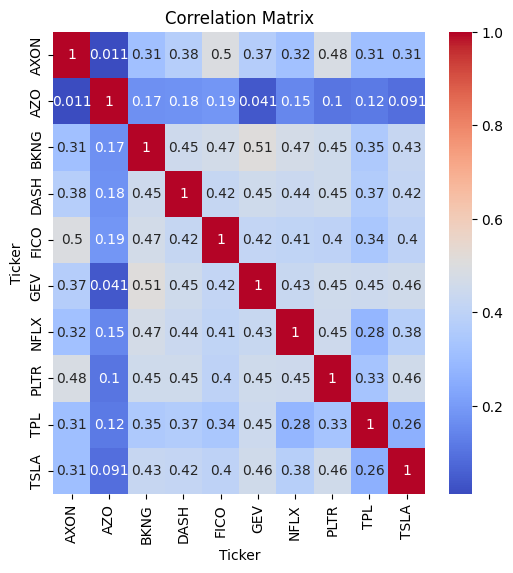

In [70]:
print('Correlation Matrix: ')
display(ef.correlation())

plt.figure(figsize=(6, 6))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

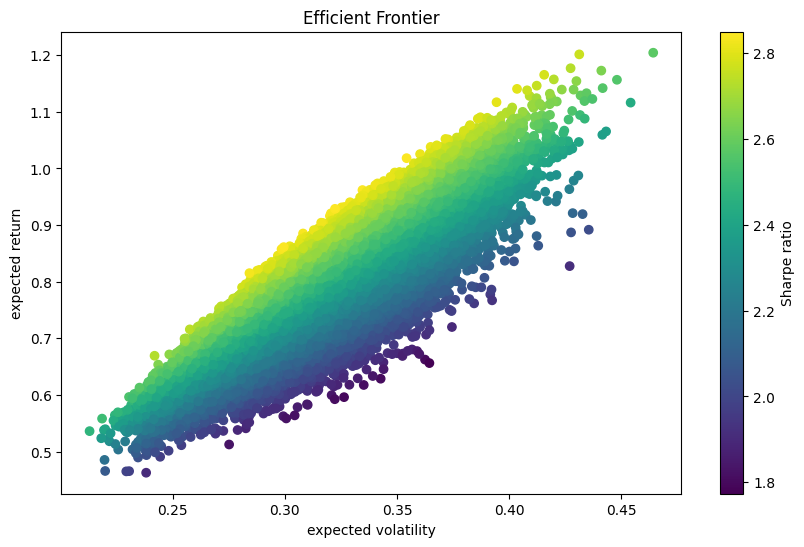

In [71]:
returnCol, volatilityCol, sharpe_ratio, optimal_weights = ef.MonteCarlo()

plt.figure(figsize = (10, 6))
plt.scatter(volatilityCol, returnCol, c = sharpe_ratio, cmap = 'viridis')
plt.title('Efficient Frontier')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')
plt.show()

In [74]:
optimal_weights_table = pd.DataFrame({
    'Asset': stocks,
    'Optimal Weight': optimal_weights
})
print("Optimal Weights for Maximum Sharpe Ratio:")
display(optimal_weights_table.style.set_table_attributes("style='display:inline'").format(precision=4))

Optimal Weights for Maximum Sharpe Ratio:


,Asset,Optimal Weight
0,PLTR,0.0882
1,TSLA,0.2009
2,BKNG,0.0036
3,TPL,0.0085
4,GEV,0.0379
5,NFLX,0.0781
6,AXON,0.1782
7,AZO,0.2323
8,FICO,0.1438
9,DASH,0.0286


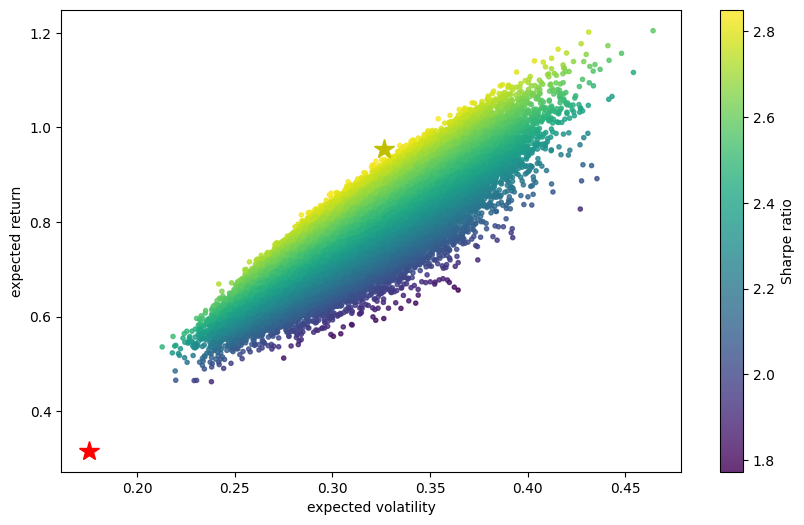

In [78]:
plt.figure(figsize = (10, 6))
plt.scatter(volatilityCol, returnCol, c = sharpe_ratio,marker='.', alpha=0.8, cmap='viridis')
plt.plot(ef.PortfolioVolatility(sharpeOptimized['x']), ef.PortfolioReturn(sharpeOptimized['x']),
         'y*', markersize = 15.0)
plt.plot(ef.PortfolioVolatility(volOptimized['x']), ef.PortfolioReturn(volOptimized['x']),
         'r*', markersize = 15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')